## Introduction
LeNet-5 is a 7 layer Convolutional Neural Network, trained on grayscale images of size 32 x 32 pixels.

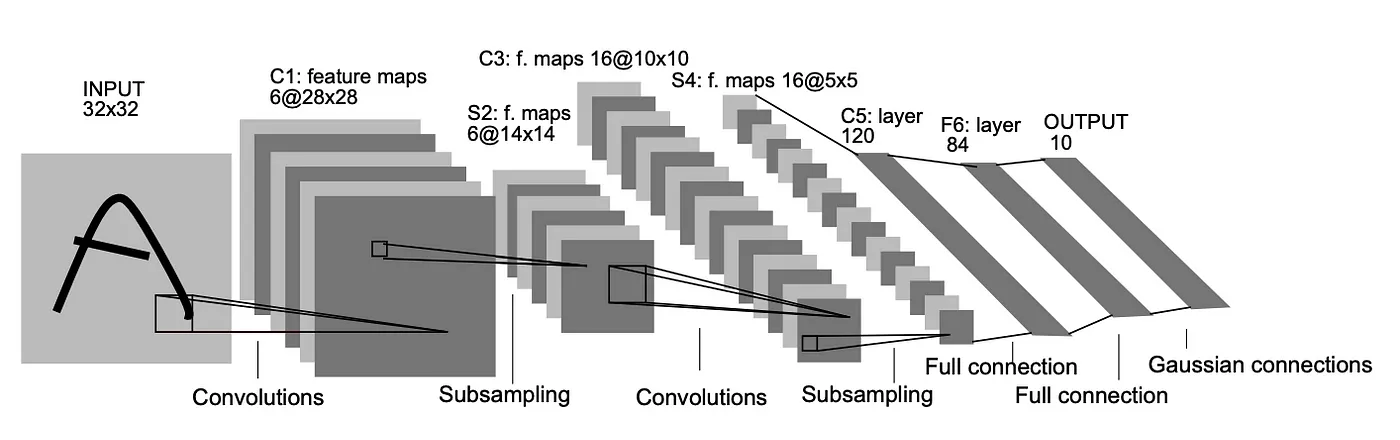

Cx — convolution layer,

Sx — subsampling (pooling) layer,

Fx — fully-connected layer,

x — index of the layer.

The formula for calculating the output size of the convolutional layer:

(W−F+2P)/S+1


**Layer 1 (C1):** The first convolutional layer with 6 kernels of size 5×5 and the stride of 1. Given the input size (32×32×1), the output of this layer is of size 28×28×6.

**Layer 2 (S2):** A subsampling/pooling layer with 6 kernels of size 2×2 and the stride of 2. The subsampling layer in the original architecture was a bit more complex than the traditionally used max/average pooling layers. I will quote [1]: “ The four inputs to a unit in S2 are added, then multiplied by a trainable coefficient, and added to a trainable bias. The result is passed through a sigmoidal function.”. As a result of non-overlapping receptive fields, the input to this layer is halved in size (14×14×6).

**Layer 3 (C3):** The second convolutional layer with the same configuration as the first one, however, this time with 16 filters. The output of this layer is 10×10×16.

**Layer 4 (S4):** The second pooling layer. The logic is identical to the previous one, but this time the layer has 16 filters. The output of this layer is of size 5×5×16.

**Layer 5 (C5):** The last convolutional layer with 120 5×5 kernels. Given that the input to this layer is of size 5×5×16 and the kernels are of size 5×5, the output is 1×1×120. As a result, layers S4 and C5 are fully-connected. That is also why in some implementations of LeNet-5 actually use a fully-connected layer instead of the convolutional one as the 5th layer. The reason for keeping this layer as a convolutional one is the fact that if the input to the network is larger than the one used in [1] (the initial input, so 32×32 in this case), this layer will not be a fully-connected one, as the output of each kernel will not be 1×1.

**Layer 6 (F6):** The first fully-connected layer, which takes the input of 120 units and returns 84 units. In the original paper, the authors used a custom activation function — a variant of the tanh activation function. For a thorough explanation, please refer to Appendix A in [1].

**Layer 7 (F7):** The last dense layer, which outputs 10 units. In [1], the authors used Euclidean Radial Basis Function neurons as activation functions for this layer.

In [42]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = "cpu"

In [43]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [44]:
def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [45]:
def validate(valid_loader, model, criterion, device):
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [46]:
def get_accuracy(model, data_loader, device):

    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):

    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    plt.style.use('default')

In [47]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    for epoch in range(0, epochs):

        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [48]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

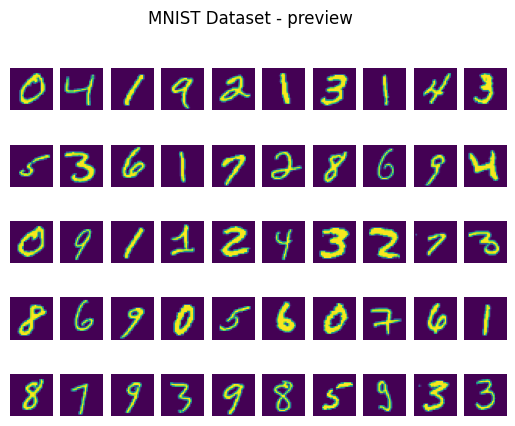

In [49]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

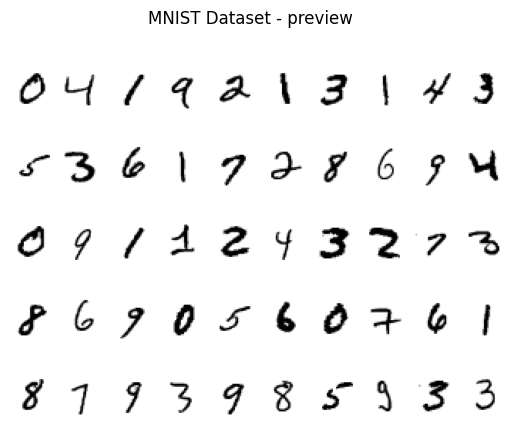

In [50]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [51]:
#using the regular tanh activation function instead of the custom one described in [1],
#using average pooling layers instead of the more complex equivalents used in the original architecture,
#replacing the Euclidean Radial Basis Function activations in the output layer with the softmax function.

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [52]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

22:17:15 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
22:17:33 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
22:17:51 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
22:18:08 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
22:18:28 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.73
22:18:46 --- Epoch: 5	Train loss: 0.0300	Valid loss: 0.0440	Train accuracy: 99.37	Valid accuracy: 98.59
22:19:06 --- Epoch: 6	Train loss: 0.0242	Valid loss: 0.0407	Train accuracy: 99.55	Valid accuracy: 98.78
22:19:25 --- Epoch: 7	Train loss: 0.0220	Valid loss: 0.0465	Train accuracy: 99.53	Valid accuracy: 98.61
22:19:44 --- Epoch: 8	Train loss: 0.0191	Valid loss: 0.0483	Train accuracy: 99.51	Valid accuracy: 98.69
22:20:02 --- Epoch: 9	Train loss: 0.0179	Valid loss: 0.0458	Trai

/tmp/ipykernel_18304/260298453.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_18304/260298453.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


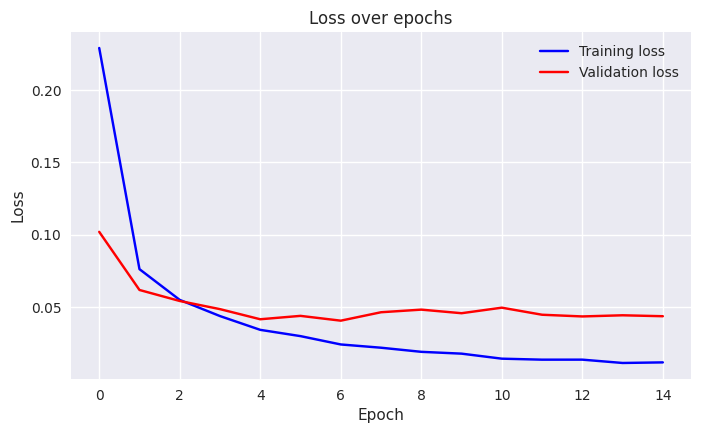

In [53]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

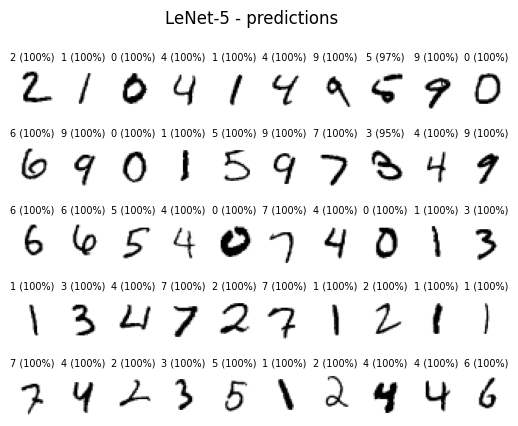

In [54]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');